# Bilevel ROF Scalar Parameter Learning
In this notebook we will propose an optimal parameter learning methodology for getting the optimal parameter for the scalar ROF image denoising model.

$$
\min \|\bar{u}-z\|^2 + \frac{\alpha}{2}\|\lambda\|^2\\
\text{s.t. }\langle \bar{u},v-\bar{u} \rangle + \lambda\|\mathbb{K}v\|_{2,1} - \lambda\|\mathbb{K}\bar{u}\|_{2,1} \ge \langle f,v-\bar{u} \rangle
$$

where $\|\cdot\|_{2,1}$ is the Total Variation seminorm.

In [36]:
using LinearAlgebra, StructuredOptimization, AbstractOperators, Plots, Distributed, Images, ImageQualityIndexes

## Cost Function and Lower Level Solver

In [2]:
# Lower Level Solver
function lower_level_solver(u,f,λ,K)
    @minimize ls(-K'*u+f) + conj(λ*norm(u,2,1,2)) with ForwardBackward(tol = 1e-3, gamma = 1/8, fast = true) 
    return -K'*(~u)+f
end

# Upper level cost
function upper_level_cost(u,z,λ,α)
    return 0.5*norm(u[:]-z[:])^2 + 0.5*α*norm(λ)^2
end

upper_level_cost (generic function with 1 method)

In [60]:
m,n = 10,10
f = tril(ones(m,n)) + 0.1*randn(m,n)
f[f .< 0] .= 0.
f[f .> 1] .= 1.
z = tril(ones(m,n))
K = Variation(size(f))
u = Variable(size(K,1)...)
α = 0.01

0.01

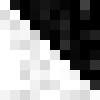

In [61]:
Gray.(f)

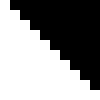

In [62]:
Gray.(z)

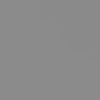

In [63]:
u_h = lower_level_solver(u,f,10,K)
Gray.(u_h)

In [64]:
step = 0.01
lambda_max = 2.0
lambda_min = eps()
lambda_range = lambda_min:step:lambda_max
costs = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    push!(costs,upper_level_cost(u_h,z,λ,α))
    #println("$λ")
end
println("done")

done


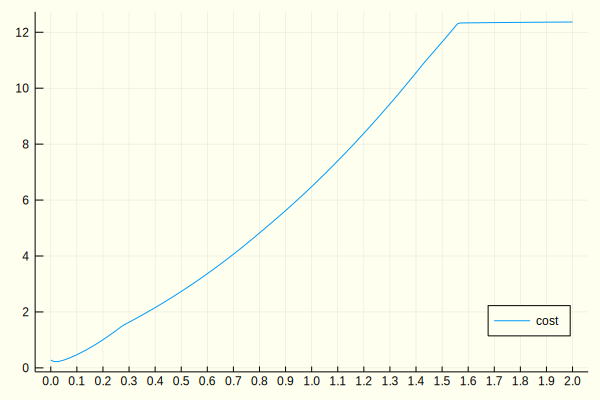

In [65]:
plot(lambda_range,costs,label="cost",xticks = 0:0.1:lambda_max, background_color = :ivory, legend=:bottomright)

## Gradient Calculation
Let us consider a reduced cost function

$$
j(\lambda) = \frac{1}{2}\|S(\lambda)-z\|^2+\frac{\alpha}{2}\|\lambda\|^2,
$$

its directional derivative will be given by

$$
j'(\lambda)h = \langle S(\lambda)-z, S'(\lambda)h \rangle + \alpha \langle \lambda, h \rangle
$$

In [435]:
include("gradient_solver.jl")

gradient_solver (generic function with 2 methods)

In [436]:
λ = 0.1
∇ = gradient_matrix(size(f))
u_h= lower_level_solver(u,f,λ,K)
grad = gradient_solver(u_h,z,λ,α,K,∇)

-49.46850571695079

In [437]:
∇ = gradient_matrix(size(f))
K = Variation(size(f))
α = 0.1

0.1

In [447]:
step = 0.1
lambda_max = 14.0
lambda_min = 0.1
lambda_range = lambda_min:step:lambda_max
grads = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    g = gradient_solver(u_h,z,λ,α,K,∇)
    push!(grads,g)
    println("$λ -> $g")
end
println("done")

done
0.1 -> -49.132074159196904
0.2 -> 49.40431470536738
0.3 -> 50.190511095825876
0.4 -> 48.87504286295297
0.5 -> 47.802055677998844
0.6 -> 47.21958704614693
0.7 -> 47.02062040257516
0.8 -> 46.94954547277209
0.9 -> 47.049038194728325
1.0 -> 47.20763896864329
1.1 -> 47.46424488298868
1.2 -> 47.81779936744959
1.3 -> 48.16679093073709
1.4 -> 48.513400938594906
1.5 -> 48.82393731765945
1.6 -> 49.281676339172115
1.7 -> 49.74930727959314
1.8 -> 50.21773354981759
1.9 -> 50.776926372959124
2.0 -> 51.247250492055514
2.1 -> 51.70386136076184
2.2 -> 52.21084132785412
2.3 -> 52.78760727727504
2.4 -> 53.310790843676365
2.5 -> 53.8179531502206
2.6 -> 54.2486649275315
2.7 -> 54.791458353455674
2.8 -> 55.35307968686098
2.9 -> 55.894773660177776
3.0 -> 56.546541535651365
3.1 -> 57.09884832991924
3.2 -> 57.58617761094262
3.3 -> 58.07058003023868
3.4 -> 58.52169374137403
3.5 -> 59.012393649289244
3.6 -> 59.5388226481641
3.7 -> 60.02795354004997
3.8 -> 60.487832441135694
3.9 -> 60.81543767732396
4.0 -> 6

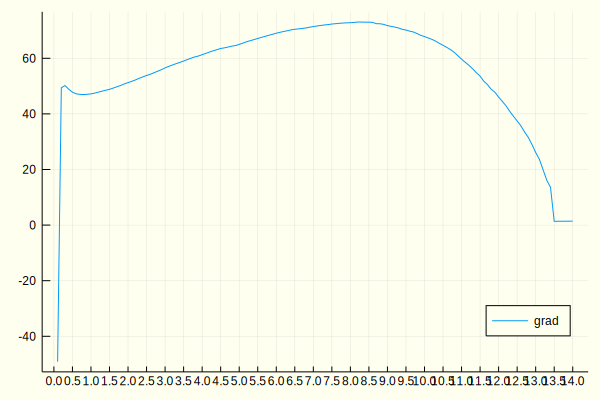

In [448]:
#plot(lambda_range,costs,label="cost",xticks = 0:1:lambda_max, background_color = :ivory, legend=:bottomright)
plot(lambda_range,grads,label="grad",xticks = 0:0.5:lambda_max, background_color = :ivory, legend=:bottomright)

## Trust Region Algorithm
We will use a nonsmooth trust region strategy to solve this problem. This method will consider a local quadratic model described by 

$$
q_k(s) = j(\lambda_k)+g_k^\top s + \frac{1}{2}s^\top H_k s
$$

where $s$ is the descent direction, $g_k$ will be the gradient at iteration $k$ and $H_k$ will be a matrix with second order information that can be obtained using SR1 or BFGS method.
The trust region radius will be $\Delta_k$ and the actual and predicted reductions are given by

$$
ared(s_k) := j(\lambda_k)-j(\lambda_k+s_k),\;pred(s_k) := j(\lambda_k)-q_k(s_k)
$$

and the step quality will be given by the following quotient

$$
\rho_k(s_k) = \frac{ared(s_k)}{pred(s_k)}
$$

In [66]:
include("trust_region_solver.jl")

trust_region_solver (generic function with 2 methods)

In [67]:
lambda_opt = trust_region_solver(lower_level_solver,upper_level_cost,15.0,f,z)

TR Iteration 1: rho_k = 1.023904624348529, radius = 0.15000000000000002, lambda = 14.900000002212318
TR Iteration 2: rho_k = 1.0431682049976687, radius = 0.22500000000000003, lambda = 14.750000005530794
TR Iteration 3: rho_k = 1.0713808021057114, radius = 0.3375, lambda = 14.525000010508508
TR Iteration 4: rho_k = 1.1163645491954821, radius = 0.5062500000000001, lambda = 14.187500017975081
TR Iteration 5: rho_k = 1.1941048870229438, radius = 0.7593750000000001, lambda = 13.68125002917494
TR Iteration 6: rho_k = 1.3447269171452088, radius = 1.1390625, lambda = 12.921875045974728
TR Iteration 7: rho_k = 1.708446699719781, radius = 1.7085937500000001, lambda = 11.782812571174409
TR Iteration 8: rho_k = 3.371965595532147, radius = 2.562890625, lambda = 10.074218858973932
TR Iteration 9: rho_k = -3.2078748088057565, radius = 1.2814453125, lambda = 10.074218858973932
TR Iteration 10: rho_k = 2.5712767108580707, radius = 1.9221679687500002, lambda = 8.792773574823574
TR Iteration 11: rho_k = 

0.019978644418897365

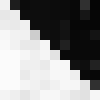

In [68]:
u_h = lower_level_solver(u,f,lambda_opt,K)
Gray.(u_h)

In [53]:
println(ssim(u_h,z))
println(ssim(f,z))

0.5983574768677417
0.5383449609611455
